# Final Project
### Machine Learning and Predictive Analytics (Spring 2024)
### Daniel Kim


In [38]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)

# Check if GPU is available`
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print("Number of logical GPUs:", len(logical_gpus))
    except RuntimeError as e:
        print("RuntimeError:", e)
else:
    print("No GPUs detected")



TensorFlow version: 2.16.1
Number of logical GPUs: 1


In [46]:
import os
import json
import pickle
import random
import numpy as np
from collections import defaultdict
from pycocotools.coco import COCO
import cv2
from matplotlib import pyplot as plt
import matplotlib.patches as patches #bounding boxes\
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
# Enable mixed precision
# Enable mixed precision
from tensorflow.keras.mixed_precision import Policy
policy = Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)


# Load Annotations and map to images

In [47]:
# Paths to the MSCOCO dataset
annotation_file_train = './annotations/instances_train2017.json'
annotation_file_val = './annotations/instances_val2017.json'
train_image_dir = './images/train2017/'
val_image_dir = './images/val2017/'
test_image_dir = './images/test2017/'

# Load COCO annotations
coco_train = COCO(annotation_file_train)
coco_val = COCO(annotation_file_val)

# Define relevant categories
# relevant_categories = ['person', 'bicycle', 'car', 'motorcycle', 'bus', 'truck', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'handbag', 'suitcase', 'backpack', 'bench', 'chair', 'table']
relevant_categories = ['person', 'bicycle', 'car', 'motorcycle', 'bus', 'truck', 'traffic light', 'fire hydrant', 'stop sign']
super_categories = set()

# Get category IDs for relevant categories
category_ids = coco_train.getCatIds(catNms=relevant_categories)
# Get category information for relevant categories
category_info = coco_train.loadCats(category_ids)
category_info


loading annotations into memory...
Done (t=53.25s)
creating index...
index created!
loading annotations into memory...
Done (t=0.48s)
creating index...
index created!


[{'supercategory': 'person', 'id': 1, 'name': 'person'},
 {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'vehicle', 'id': 3, 'name': 'car'},
 {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'},
 {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'},
 {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'},
 {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'},
 {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'},
 {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'}]

## Data Parser Class with helper methods

In [48]:
class DataParser:
    def __init__(self, annotation_file, train_image_dir, val_image_dir, test_image_dir, relevant_categories=None):
        """
        Initialize the DataParser with paths and relevant categories.

        Args:
        - annotation_file (str): Path to the COCO annotation file.
        - train_image_dir (str): Directory path for training images.
        - val_image_dir (str): Directory path for validation images.
        - test_image_dir (str): Directory path for test images.
        - relevant_categories (list): List of relevant category names for filtering.
        """
        self.coco = COCO(annotation_file)
        self.image_dirs = {
            'train': train_image_dir,
            'val': val_image_dir,
            'test': test_image_dir,
        }
        self.relevant_categories = relevant_categories if relevant_categories else []
        self.relevant_category_ids = self.coco.getCatIds(catNms=self.relevant_categories)
        self.im_dict = {}

    def get_relevant_imgIds(self, dataset_type='train', limit=None):
        """
        Get image IDs for images containing relevant categories. Optionally limit the number of IDs returned.

        Args:
        - dataset_type (str): Type of dataset ('train', 'val', 'test') to filter images by.
        - limit (int, optional): Maximum number of image IDs to return. Returns all IDs if None.

        Returns:
        - list: List of image IDs containing relevant categories, limited by 'limit' if provided.
        """
        if dataset_type not in self.image_dirs:
            raise ValueError(f"Dataset type '{dataset_type}' is not recognized. Expected one of {list(self.image_dirs.keys())}.")
        relevant_img_ids = []
        for img_id in self.coco.getImgIds():
            ann_ids = self.coco.getAnnIds(imgIds=[img_id], catIds=self.relevant_category_ids, iscrowd=False)
            if ann_ids:
                relevant_img_ids.append(img_id)
        return relevant_img_ids

    def check_missing_files(self, img_ids, dataset_type):
        """
        Check for missing image files in the dataset directories.
        """
        missing_files = []
        valid_img_ids = []
        for img_id in img_ids:
            img_info = self.coco.loadImgs(img_id)[0]
            img_path = os.path.join(self.image_dirs[dataset_type], img_info['file_name'])
            if not os.path.isfile(img_path):
                missing_files.append(img_id)
            else:
                valid_img_ids.append(img_id)
        return missing_files, valid_img_ids

    def parse_data(self):
        """
        Parse the COCO data to populate internal dictionaries for images, annotations, and categories.
        """
        for img_id in self.coco.getImgIds():
            img_info = self.coco.loadImgs(img_id)[0]
            ann_ids = self.coco.getAnnIds(imgIds=img_info['id'], catIds=self.relevant_category_ids, iscrowd=None)
            anns = self.coco.loadAnns(ann_ids)
            if anns:  # if there are annotations for the relevant categories
                self.im_dict[img_id] = {
                    'image_info': img_info,
                    'annotations': anns
                }

    def save_data(self, file_path):
        """
        Save the parsed data to a file.

        Args:
        - file_path (str): Path to the file where the data will be saved.
        """
        with open(file_path, 'wb') as f:
            pickle.dump(self.im_dict, f)

    def load_data_from_file(self, file_path):
        """
        Load the parsed data from a file.

        Args:
        - file_path (str): Path to the file from where the data will be loaded.
        """
        with open(file_path, 'rb') as f:
            self.im_dict = pickle.load(f)
            
    def check_and_open_image(self, img_id, dataset_type='train'):
        """
        Check if an image exists and open it, given an img_id and dataset type,
        Also visualize bounding boxes and labels.
        """
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.image_dirs[dataset_type], img_info['file_name'])

        if os.path.isfile(img_path):
            print(f"File exists at {img_path}")
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for matplotlib

            fig, ax = plt.subplots(figsize=(10, 10))
            ax.imshow(img)

            ann_ids = self.coco.getAnnIds(imgIds=img_id)
            anns = self.coco.loadAnns(ann_ids)
            for ann in anns:
                bbox = ann['bbox']
                x, y, w, h = bbox
                rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                label = self.coco.loadCats(ann['category_id'])[0]['name']
                plt.text(x, y-5, label, color='red', fontweight='bold')

            plt.axis('off')
            plt.show()
        else:
            print(f"No file found at {img_path}")

    def get_imgIds(self):
        """
        Get a list of all image IDs.

        Returns:
        list: List of image IDs.
        """
        return list(self.im_dict.keys())

    def get_annIds(self, im_ids):
        """
        Get annotation IDs for given image IDs.

        Parameters:
        im_ids (list or int): Image ID or list of image IDs.

        Returns:
        list: List of annotation IDs.
        """
        im_ids = im_ids if isinstance(im_ids, list) else [im_ids]
        return [ann['id'] for im_id in im_ids for ann in self.annIm_dict[im_id]]

    def load_anns(self, ann_ids):
        """
        Load annotations for given annotation IDs.

        Parameters:
        ann_ids (list or int): Annotation ID or list of annotation IDs.

        Returns:
        list: List of annotations.
        """
        ann_ids = ann_ids if isinstance(ann_ids, list) else [ann_ids]
        return [self.annId_dict[ann_id] for ann_id in ann_ids]

    def load_cats(self, class_ids):
        """
        Load categories for given class IDs.

        Parameters:
        class_ids (list or int): Class ID or list of class IDs.

        Returns:
        list: List of categories.
        """
        class_ids = class_ids if isinstance(class_ids, list) else [class_ids]
        return [self.cat_dict[class_id] for class_id in class_ids]

    def get_imgLicenses(self, im_ids):
        """
        Get licenses for given image IDs.

        Parameters:
        im_ids (list or int): Image ID or list of image IDs.

        Returns:
        list: List of licenses.
        """
        im_ids = im_ids if isinstance(im_ids, list) else [im_ids]
        lic_ids = [self.im_dict[im_id]["license"] for im_id in im_ids]
        return [self.licenses_dict[lic_id] for lic_id in lic_ids]

    def load_and_preprocess_image(self, img_path, img_size=(224, 224)):
        """
        Load and preprocess an image.

        Parameters:
        - img_path: The full path to the image file.
        - img_size: The target size of the image.

        Returns:
        A preprocessed image.
        """
        # Load image
        img = cv2.imread(img_path)
        # Convert color space if needed, e.g., from BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Resize image
        img = cv2.resize(img, img_size)
        # Normalize pixel values to [0, 1] (if needed)
        img = img / 255.0

        return img

    def load_and_preprocess_dataset(self, img_ids, dataset_type='train', img_size=(224, 224)):
        """
        Load and preprocess images and their labels for given image IDs.

        Args:
        - img_ids (list): List of COCO image IDs.
        - dataset_type (str): Type of dataset ('train', 'val', 'test').
        - img_size (tuple): Desired (width, height) for resizing images.

        Returns:
        - X (np.array): Array of preprocessed images.
        - y (np.array): Array of labels corresponding to the images.
        """
        if dataset_type not in self.image_dirs:
            raise ValueError(f"Dataset type '{dataset_type}' is not recognized. Expected one of {list(self.image_dirs.keys())}.")

        X, y = [], []
        for img_id in img_ids:
            img_info = self.coco.loadImgs(img_id)[0]
            img_path = os.path.join(self.image_dirs[dataset_type], img_info['file_name'])
            img = self.load_and_preprocess_image(img_path, img_size)

            # Initialize label vector for the presence of relevant categories.
            label_vector = np.zeros(len(self.relevant_categories))
            ann_ids = self.coco.getAnnIds(imgIds=img_id, catIds=self.relevant_category_ids, iscrowd=None)
            anns = self.coco.loadAnns(ann_ids)
            for ann in anns:
                category_id = ann['category_id']
                if category_id in self.relevant_category_ids:
                    category_index = self.relevant_category_ids.index(category_id)
                    label_vector[category_index] = 1  # Mark presence of this category

            X.append(img)
            y.append(label_vector)

        return np.array(X), np.array(y)
    



loading annotations into memory...
Done (t=34.44s)
creating index...
index created!
loading annotations into memory...
Done (t=0.25s)
creating index...
index created!
Training images: 72120, Validation images: 3052, Test images: 3052
File exists at ./images/train2017/000000391895.jpg


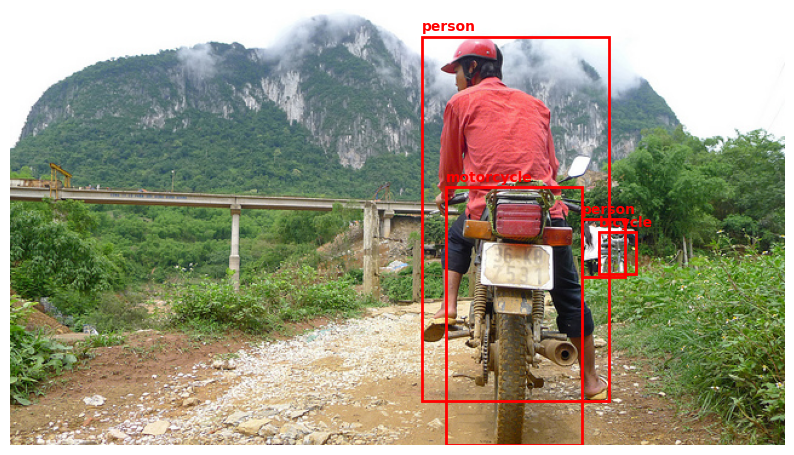

In [ ]:
# Step 2: Initialize DataParser

# coco_parser = DataParser(annotation_file, train_image_dir, val_image_dir, test_image_dir, relevant_categories)

# # Step 3: Get image IDs for training, validation, and test sets
# image_ids_train = coco_parser.get_relevant_imgIds('train', limit=10000)
# image_ids_val = coco_parser.get_relevant_imgIds('val', limit=3000)
# image_ids_test = coco_parser.get_relevant_imgIds('test', limit=3000)

coco_parser_train = DataParser(annotation_file_train, train_image_dir, val_image_dir, test_image_dir, relevant_categories)
coco_parser_val = DataParser(annotation_file_val, train_image_dir, val_image_dir, test_image_dir, relevant_categories)

# Get image IDs
image_ids_train = coco_parser_train.get_relevant_imgIds('train')
image_ids_val = coco_parser_val.get_relevant_imgIds('val')
image_ids_test = coco_parser_val.get_relevant_imgIds('test')
# Step 4: Print the counts of images
print(f"Training images: {len(image_ids_train)}, Validation images: {len(image_ids_val)}, Test images: {len(image_ids_test)}")

# Step 5: Save parsed data
coco_parser.parse_data()
coco_parser.save_data('parsed_data.pkl')

# Step 6: Load parsed data
coco_parser.load_data_from_file('parsed_data.pkl')

# Step 7: Check and open an image (optional, for validation purposes)
coco_parser.check_and_open_image(image_ids_train[0], 'train')

In [70]:
def create_tf_data_generator(datagen, img_ids, batch_size, coco_parser, dataset_type='train', img_size=(224, 224)):
    def generator():
        for start in range(0, len(img_ids), batch_size):
            end = min(start + batch_size, len(img_ids))
            batch_img_ids = img_ids[start:end]
            X, y = [], []
            for img_id in batch_img_ids:
                img_info = coco_parser.coco.loadImgs(img_id)[0]
                img_path = os.path.join(coco_parser.image_dirs[dataset_type], img_info['file_name'])
                if os.path.isfile(img_path):
                    img = coco_parser.load_and_preprocess_image(img_path, img_size)
                    label_vector = np.zeros(len(coco_parser.relevant_categories))
                    ann_ids = coco_parser.coco.getAnnIds(imgIds=img_id, catIds=coco_parser.relevant_category_ids, iscrowd=None)
                    anns = coco_parser.coco.loadAnns(ann_ids)
                    for ann in anns:
                        category_id = ann['category_id']
                        if category_id in coco_parser.relevant_category_ids:
                            category_index = coco_parser.relevant_category_ids.index(category_id)
                            label_vector[category_index] = 1
                    X.append(img)
                    y.append(label_vector)
            if X and y:
                yield np.array(X), np.array(y)
    
    dataset = tf.data.Dataset.from_generator(generator, output_signature=(tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32), tf.TensorSpec(shape=(None, len(coco_parser.relevant_categories)), dtype=tf.float32)))
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE).repeat()
    return dataset


# Check for missing files
missing_train_files, valid_train_img_ids = coco_parser_train.check_missing_files(image_ids_train, 'train')
missing_val_files, valid_val_img_ids = coco_parser_val.check_missing_files(image_ids_val, 'val')
missing_test_files, valid_test_img_ids = coco_parser_val.check_missing_files(image_ids_test, 'test')

print(f"Missing train files: {len(missing_train_files)}")
print(f"Missing val files: {len(missing_val_files)}")
print(f"Missing test files: {len(missing_test_files)}")
if missing_train_files:
    print(f"Example missing train file ID: {missing_train_files[0]}")
if missing_val_files:
    print(f"Example missing val file ID: {missing_val_files[0]}")
if missing_test_files:
    print(f"Example missing test file ID: {missing_test_files[0]}")

# Proceed with available data
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_dataset = create_tf_data_generator(train_datagen, valid_train_img_ids, 32, coco_parser_train, 'train')
val_dataset = create_tf_data_generator(val_test_datagen, valid_val_img_ids, 32, coco_parser_val, 'val')
test_dataset = create_tf_data_generator(val_test_datagen, valid_test_img_ids, 32, coco_parser_val, 'test')

# Define input shape and number of classes
input_shape = (224, 224, 3)
num_classes = len(relevant_categories)


Missing train files: 0
Missing val files: 0
Missing test files: 3052
Example missing test file ID: 397133


In [82]:
import os
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import numpy as np
import time

def build_base_cnn(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='sigmoid'))
    return model

def build_mobilenetv2(input_shape, num_classes):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

def build_resnet50(input_shape, num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [83]:
# Training and Evaluation Function
def train_and_evaluate_model(model, train_generator, val_generator, test_generator, model_name, batch_size, epochs):
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

    checkpoint_callback = ModelCheckpoint(filepath=f'{model_name.lower()}_best_model.keras', monitor='val_loss', save_best_only=True)

    history = model.fit(
        train_generator,
        steps_per_epoch=max(1, len(valid_train_img_ids) // batch_size),
        validation_data=val_generator,
        validation_steps=max(1, len(valid_val_img_ids) // batch_size),
        epochs=epochs,
        callbacks=[checkpoint_callback]
    )
    print(f"{model_name} Training Complete")

    test_steps = max(1, len(valid_test_img_ids) // batch_size)
    if test_steps > 0:
        test_loss, test_acc = model.evaluate(test_generator, steps=test_steps)
        print(f'Test accuracy of {model_name}: {test_acc:.2f}')
    else:
        print("No valid test steps available for evaluation")

    model.save(f'{model_name.lower()}_model.keras')
    print(f"{model_name} Model Saved")

    return history

# Measure Model Information
def get_model_size(model):
    model.save('temp_model.keras')
    model_size = os.path.getsize('temp_model.keras') / (1024 * 1024)
    os.remove('temp_model.keras')
    return model_size

def print_model_info(model, model_name):
    print(f"\n{model_name} Summary:")
    model.summary()
    model_size = get_model_size(model)
    print(f"{model_name} Size: {model_size:.2f} MB")
    total_params = model.count_params()
    print(f"{model_name} Total Parameters: {total_params:,}")

def measure_latency(model, input_shape):
    dummy_input = np.random.random((1, *input_shape)).astype(np.float32)
    model.predict(dummy_input)
    start_time = time.time()
    model.predict(dummy_input)
    latency = (time.time() - start_time) * 1000
    return latency

In [87]:
input_shape = (224, 224, 3)
num_classes = 9
epochs = 3  # Reduced number of epochs
batch_size = 256  # Increased batch size for faster training

# Assuming valid_train_img_ids, valid_val_img_ids, valid_test_img_ids are defined

# Train and evaluate Base Model
print("\n Training Baseline \n")
base_model = build_base_cnn(input_shape, num_classes)
history_base = train_and_evaluate_model(base_model, train_generator, val_generator, test_generator, "Base Model", batch_size, epochs)




 Training Baseline 



/opt/anaconda3/envs/tf_mac/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3


KeyboardInterrupt: 

In [88]:
# Train and evaluate MobileNetV2
print("\nTraining MobileNetV2 \n")
mobilenetv2_model = build_mobilenetv2(input_shape, num_classes)
history_mobilenetv2 = train_and_evaluate_model(mobilenetv2_model, train_generator, val_generator, test_generator, "MobileNetV2", batch_size, epochs)




Training MobileNetV2 

Epoch 1/3


KeyboardInterrupt: 

In [ ]:
# Train and evaluate ResNet50
print("\nTraining ResNet50 \n")
resnet50_model = build_resnet50(input_shape, num_classes)
history_resnet50 = train_and_evaluate_model(resnet50_model, train_generator, val_generator, test_generator, "ResNet50", batch_size, epochs)



In [ ]:
# Measure and print model info
print_model_info(base_model, "Base Model")
print('\n')
print_model_info(mobilenetv2_model, "MobileNetV2")
print('\n')
print_model_info(resnet50_model, "ResNet50")
print('\n')
# Measure and print latency
base_model_latency = measure_latency(base_model, input_shape)
mobilenetv2_latency = measure_latency(mobilenetv2_model, input_shape)
resnet50_latency = measure_latency(resnet50_model, input_shape)

print(f"Base Model Inference Latency: {base_model_latency:.2f} ms")
print('\n')
print(f"MobileNetV2 Inference Latency: {mobilenetv2_latency:.2f} ms")
print('\n')
print(f"ResNet50 Inference Latency: {resnet50_latency:.2f} ms")